In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import glob
from shutil import copyfile

In [2]:
print(len(os.listdir('cell_images/Uninfected')))
print(len(os.listdir('cell_images/Parasitized')))

13780
13780


In [3]:
dir = "cell_images/"

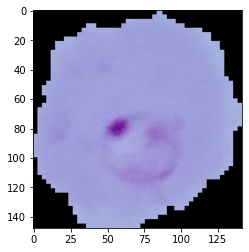

In [4]:
Categories = ['Parasitized', 'Uninfected']

for categories in Categories:
    path = os.path.join(dir, categories)
    for img in os.listdir(path):
        img1 = cv2.imread(os.path.join(path , img))
        plt.imshow(img1)
        plt.show()
        break
    break

In [5]:
img1.shape

(148, 142, 3)

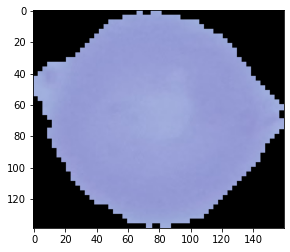

In [6]:
Categories = ['Uninfected', 'Parasitized']

for categories in Categories:
    path = os.path.join(dir, categories)
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path , img))
        plt.imshow(img)
        plt.show()
        break
    break

In [7]:
img.shape

(139, 160, 3)

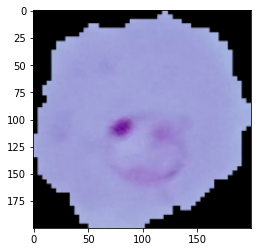

In [8]:
img_size = 200 #this size is good 

new_array = cv2.resize(img1, (img_size, img_size)) # for dogs
plt.imshow(new_array)
plt.show()

In [9]:
uninfected = os.path.join("cell_images/Uninfected")
parasitized = os.path.join("cell_images/Parasitized")

healthy= os.listdir(uninfected)
infected= os.listdir(parasitized)


#parameters for our graph; we'll output images in a 4x4 configuration
nrows =4
ncols=4

#Index for iterating over images
pic_index= 0

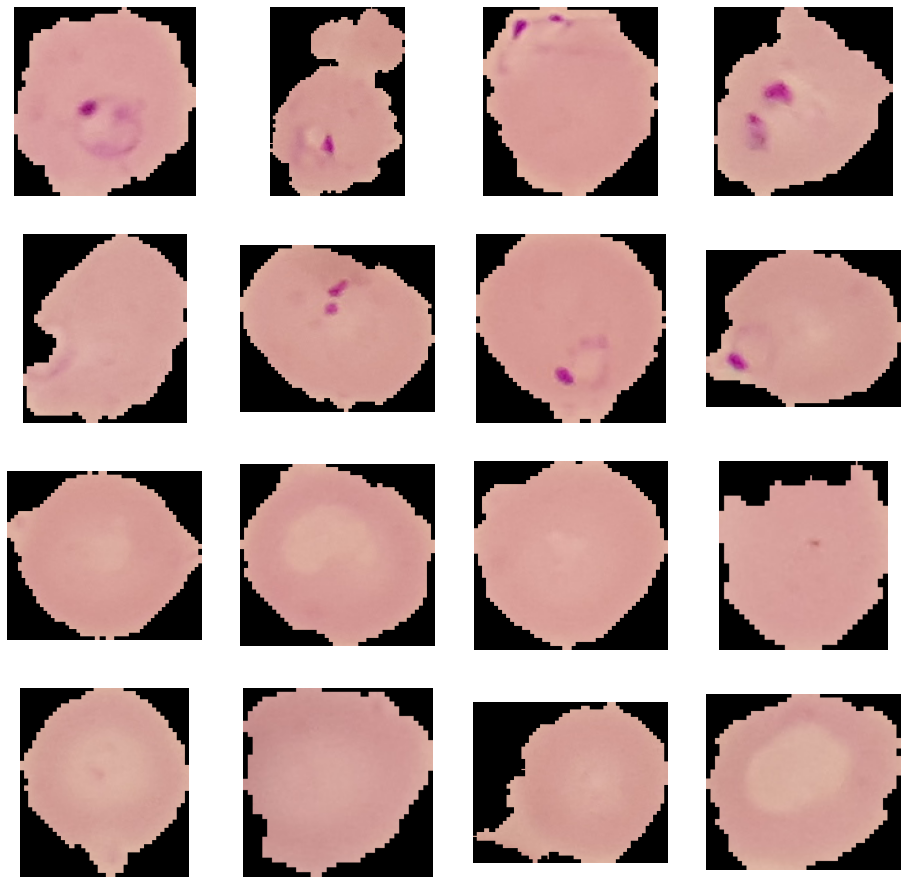

In [10]:
import matplotlib.image as mpimg
fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows *4)

pic_index += 8
next_infected_pix = [os.path.join(parasitized, fname)
               for fname in infected[pic_index-8:pic_index]]

next_healthy_pix = [os.path.join(uninfected, fname)
               for fname in healthy[pic_index-8:pic_index]]

for i, img_path in enumerate(next_infected_pix + next_healthy_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis("off")
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

make  directories and split data in train and validation

In [11]:
try:
    os.mkdir("cell")
    os.mkdir("cell/training")
    os.mkdir("cell/testing")
    os.mkdir("cell/validation")
    
    os.mkdir("cell/training/infected")
    os.mkdir("cell/training/healthy")
    
    os.mkdir("cell/validation/infected")
    os.mkdir("cell/validation/healthy")
    
    os.mkdir("cell/testing/infected")
    os.mkdir("cell/testing/healthy")
except OSError:
    pass

In [12]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


healthy_SOURCE_DIR = "cell_images/Uninfected/"
TRAINING_healthy_DIR = "cell/training/healthy/"
validation_healthy_DIR = "cell/validation/healthy/"

infected_SOURCE_DIR = "cell_images/Parasitized/"
TRAINING_infected_DIR = "cell/training/infected/"
validation_infected_DIR = "cell/validation/infected/"

split_size = .9
split_data(healthy_SOURCE_DIR, TRAINING_healthy_DIR, validation_healthy_DIR , split_size)
split_data(infected_SOURCE_DIR, TRAINING_infected_DIR, validation_infected_DIR, split_size)

In [3]:
print(len(os.listdir("cell/training/healthy/")))
print(len(os.listdir("cell/training/infected/")))

print(len(os.listdir("cell/validation/healthy/")))
print(len(os.listdir("cell/validation/infected/")))

13623
13636
2599
2612


Now we split our data in training and validation data

In [4]:
train = "cell/training/"
validation = "cell/validation/"

### Data Generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.) #rescale
train_data = train_datagen.flow_from_directory(train,
                                              batch_size = 20,
                                              class_mode = "binary",
                                              target_size = (150,150)) # resize

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) # rescale
validaton_data = validation_datagen.flow_from_directory(validation,
                                                       batch_size = 20,
                                                       class_mode = "binary",
                                                       target_size = (150,150))

Found 27257 images belonging to 2 classes.
Found 5211 images belonging to 2 classes.


In [10]:
train_data.class_indices

{'healthy': 0, 'infected': 1}

### Base Model

In [7]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), padding = "same",input_shape= (150,150,3)))
model.add(layers.Conv2D(32,(3,3),padding = "same"))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(32,(3,3),padding="same"))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3),padding="same"))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(523))
model.add(layers.ReLU())

model.add(layers.Dense(84))
model.add(layers.ReLU())

model.add(layers.Dense(1))
model.add(layers.Activation("sigmoid"))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
re_lu (ReLU)                 (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [9]:
from keras.optimizers import Adam

model.compile(loss = "binary_crossentropy",
             optimizer = Adam(lr=0.001),
             metrics = ["accuracy"])

In [10]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
history = model.fit_generator(train_data,epochs = 21, 
                              steps_per_epoch = 27257//20, # images = batch_size * steps
                              validation_data = validaton_data,
                              validation_steps=5211//20,
                             callbacks=callbacks_list)

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
1362/1362 [==============================] - 92s 59ms/step - loss: 0.6165 - accuracy: 0.6243 - val_loss: 0.1491 - val_accuracy: 0.9525

Epoch 00001: val_accuracy improved from -inf to 0.95250, saving model to weights.best.hdf5
Epoch 2/21
1362/1362 [==============================] - 92s 67ms/step - loss: 0.1460 - accuracy: 0.9539 - val_loss: 0.1523 - val_accuracy: 0.9523

Epoch 00002: val_accuracy did not improve from 0.95250
Epoch 3/21
1362/1362 [==============================] - 212s 156ms/step - loss: 0.1267 - accuracy: 0.9607 - val_loss: 0.1229 - val_accuracy: 0.9523

Epoch 00003: val_accuracy did not improve from 0.95250
Epoch 4/21
1362/1362 [==============================] - 238s 175ms/step - loss: 0.1104 - accuracy: 0.9627 - val_loss: 0.1000 - val_accuracy: 0.9685

Epoch 00004: val_accuracy improved from 0.95250 to 0.96846, saving model to weights.best.hdf5
Epoch 5/21
1362/1362 [==============================] - 328s 241ms/step - loss: 0.0922 - accuracy: 0.9689 - val_l

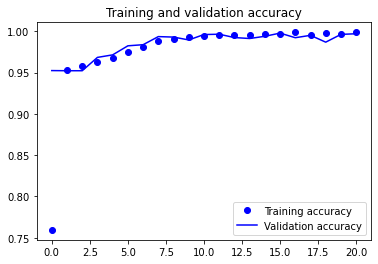

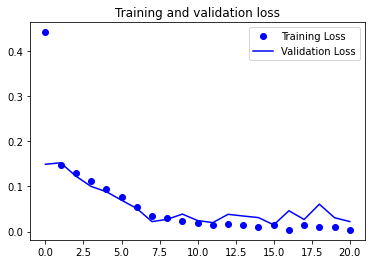

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() 

In [14]:
#save model architecture
model_json = model.to_json()
with open("basemodel.json", "w") as json_file:
    json_file.write(model_json)

In [16]:
from keras.models import model_from_json
# load json and create model
json_file = open('basemodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights.best.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [17]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
re_lu (ReLU)                 (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

## Data augmentation ,  pretrained model

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

In [7]:
train_ds = train_datagen.flow_from_directory(train,
                                              batch_size = 20,
                                              class_mode = "binary",
                                              target_size = (150,150)) # resize

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) # rescale
validaton_data = validation_datagen.flow_from_directory(validation,
                                                       batch_size = 20,
                                                       class_mode = "binary",
                                                       target_size = (150,150))

Found 27257 images belonging to 2 classes.
Found 5211 images belonging to 2 classes.


In [8]:
train_ds.class_indices

{'healthy': 0, 'infected': 1}

In [9]:
from keras.applications import VGG16
vgg = VGG16(weights= "imagenet",include_top=False, input_shape = (150,150,3))

In [10]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
from keras.models import Model
from keras import layers, models
  
x = layers.Flatten()(vgg.output)
x = layers.Dense(523, activation=('relu'))(x)
x = layers.Dense(84, activation = ('relu'))(x)
prediction = layers.Dense(1, activation="sigmoid")(x)

In [14]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
from keras.optimizers import Adam

model.compile(loss = "binary_crossentropy",
             optimizer = Adam(lr=0.001),
             metrics = ["accuracy"])

In [17]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="tranfer_model.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit_generator(train_ds,epochs = 21, 
                              steps_per_epoch = 27257//20, # images = batch_size * steps
                              validation_data = validaton_data,
                              validation_steps=5211//20,
                             callbacks=callbacks_list)

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/21
1362/1362 [==============================] - 669s 484ms/step - loss: 0.4161 - accuracy: 0.8175 - val_loss: 0.2239 - val_accuracy: 0.9173

Epoch 00001: val_accuracy improved from -inf to 0.91731, saving model to tranfer_model.best.hdf5
Epoch 2/21
1362/1362 [==============================] - 1022s 751ms/step - loss: 0.2941 - accuracy: 0.8809 - val_loss: 0.2122 - val_accuracy: 0.9127

Epoch 00002: val_accuracy did not improve from 0.91731
Epoch 3/21
1362/1362 [==============================] - 315s 231ms/step - loss: 0.2740 - accuracy: 0.8900 - val_loss: 0.1880 - val_accuracy: 0.9219

Epoch 00003: val_accuracy improved from 0.91731 to 0.92192, saving model to tranfer_model.best.hdf5
Epoch 4/21
1362/1362 [==============================] - 395s 290ms/step - loss: 0.2728 - accuracy: 0.8881 - val_loss: 0.2474 - val_accuracy: 0.8960

Epoch 00004: val_accuracy did not improve from 0.92192
Epoch 5/21
1362/1362 [==============================] - 472s 346ms/step - loss: 0.2670 - accurac

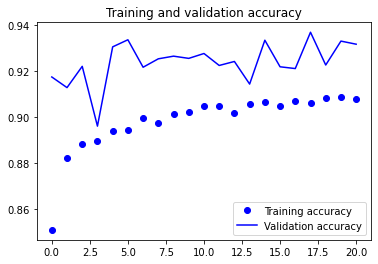

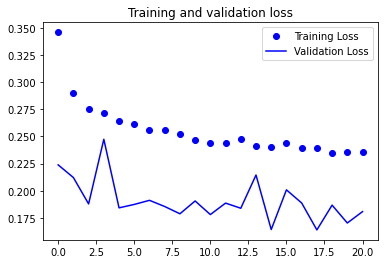

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() 